# DIABETES LEARNING



In [1]:
isGoogleColab = True

# Notes

- check these blog posts: https://muellerzr.github.io/fastblog/ and his course: https://walkwithfastai.com/intro.contribute
- learner.export() already save all the transforms that will be applied during inference time, so it is not necessary to resize or normalize stats. If running outside the model outside fastai, check: https://forums.fast.ai/t/do-we-need-to-normalize-single-image-before-running-predict-function-on-it/44301/4
- to_fp16() is mixed precision
- item_tfms already apply the resize before collating the images in a batch. So it is not necessary to do this manually
- aug_tfms will only be applied on train_dl. validation and test will not be affected
- test_dl is a testing dataloader that uses the same transforms as train_dl and valid_dl, but with new data
- check images cleaner in the future
- cross validation: check walkwithfastai video 3 or https://forums.fast.ai/t/is-it-possible-to-implement-cross-validation-in-fastai/44961/15 or https://forums.fast.ai/t/am-i-doing-k-fold-cross-validation-right/84738/6  
- stratification in Kfold and Train_Test split for Multi Label problems is not straighforward. Check http://scikit.ml/index.html#. Use for now balanced datasets!!!!



# Installation

## Kill all other GPU sessions

Run the first time this cell. Then, restart your session and run again the notebook without this code.

In [ ]:
  #!kill -9 -1

## Keep Session Alive

Put this javascript code in the browser console

In [ ]:
# function ClickConnect(){
#    console.log("Working");
#    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
# }  setInterval(ClickConnect,300000)

## Update ipython/ipykernel (Colab)

The Colab session can fail when running the first time this cell. Just run it a second time.

In [ ]:
# This magic cell should be put first in your colab notebook. 
# It'll automatically upgrade colab's really antique ipython/ipykernel to their 
# latest versions which are required for packages like ipyexperiments 

# from packaging import version
# import IPython, ipykernel
# IPython.__version__
# if version.parse(IPython.__version__) <= version.parse("5.5.0"):
#     !pip install -q --upgrade ipython
#     !pip install -q --upgrade ipykernel
    
#     import os
#     import signal
#     os.kill(os.getpid(), signal.SIGTERM)
# print(f"ipykernel=={ipykernel.__version__}")
# print(f"IPython=={IPython.__version__}")

In [ ]:
# new (large)
# !pip install ipyexperiments
# new (large)
# from ipyexperiments import IPyExperimentsPytorch
# exp = IPyExperimentsPytorch()

## Check GPU e CPU RAM

In [ ]:
if isGoogleColab:
    
    import torch
    from pynvml import *
    nvmlInit()
    def log_mem():
        h = nvmlDeviceGetHandleByIndex(0)
        info = nvmlDeviceGetMemoryInfo(h)
        print(f'GPU total Memory    : {info.total}')
        print(f'GPU free Memory     : {info.free}')
        print(f'GPU Memory used     : {info.used}')
    torch.ones(1).to(0)
    log_mem()

    !nvidia-smi

GPU total Memory    : 15843721216
GPU free Memory     : 14723842048
GPU Memory used     : 1119879168
Mon Aug 30 21:57:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W /  70W |   1068MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-----------

## Mount the Google Drive to Google Colab

In [ ]:
if isGoogleColab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    path_to_drive = "/content/drive/MyDrive/Colab Notebooks/"
    sys.path.append(path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/') #make src files importable

else:
    path_to_drive = "./"

Mounted at /content/drive


In [ ]:
#!unrar x "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/augmentedDataset_v2.rar" "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/"
#!unrar x "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/augmentedDataset.rar" # extrai local
#!unzip "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/database.zip" -d "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/"

## Install Deep Learning libraries

In [ ]:
# !pip install torch==1.9.0
# !pip install fastai==2.4.1 
# !pip install wandb

##restart runtime!!!

In [ ]:
import sys; print('Python:',sys.version)
import torch; print('Pytorch:',torch.__version__)
import fastai; print('Fastai:',fastai.__version__)

Python: 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Pytorch: 1.9.0+cu102
Fastai: 2.4.1


# Train your model

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.callback.wandb import *
import torch
import torchvision
from PIL import Image
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Data

In [ ]:
path = path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/' 
path_anno = path + 'gt/'
path_img = path + 'done/'

#funcao que pega a imagem de anotacoes correspondente, dado a imagem original de entrada
get_y_fn = lambda x : path_anno + '/' + f'{x.stem}_GT.png'

In [ ]:
np.random.seed(2) #mesma semente para todas as vezes que executar
randomSeed = 2

label_fnames = get_image_files(path_anno)
print(label_fnames[:3])
fnames = get_image_files(path_img)
print(fnames[:3])

len(fnames), len(label_fnames)

[Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/gt/136_GT.png'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/gt/570_GT.png'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/gt/900_GT.png')]
[Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/done/176.jpg'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/done/976.jpg'), Path('/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/done/469.jpg')]


(431, 431)

In [ ]:
codes = np.loadtxt(path + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf')
codesId = [code.split(": ")[0] for code in codes]
codes = [code.split(": ")[1] for code in codes] #pega apenas o nome de cada classe e ignora o ID
len(codes)

5

In [ ]:
### fix GT ids: masks must be [0, 1, …, K-1] where K is the number of categories

def createAdjustedGroundTruthIds(fnames):
  "Gather the codes from a list of `fnames`"
  vals = set()
  for fname in fnames:
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(sorted(vals))

  for i,val in enumerate(vals):
    adjustedGroundTruthIds[i] = vals[i]

def get_y_fn(item):
  "Grab a mask from a `filename` and adjust the pixels based on `adjustedGroundTruthIds`"
  itemGtPath = path_anno + '/' + f'{item.stem}_GT.png'
  msk = np.array(PILMask.create(itemGtPath))
  mx = np.max(msk)
  for i, val in enumerate(adjustedGroundTruthIds):
    msk[msk==adjustedGroundTruthIds[i]] = val
  return PILMask.create(msk)

adjustedGroundTruthIds = dict()
adjustedGroundTruthIds = {i : int(codesId[i]) for i in range(len(codes))}
# createAdjustedGroundTruthIds(label_fnames)

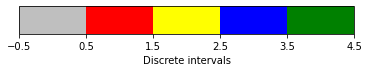

In [ ]:
# define colormap for masks

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = matplotlib.colors.ListedColormap([np.random.rand(3,) for i in range(0,len(codes))])
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.75, .75, .75, 1.0) # nao alimento -> cinza
cmaplist[1] = "red" # nao registrado
cmaplist[2] = "yellow" #arroz integral
cmaplist[3] = "blue" #arroz branco
cmaplist[4] = "green" #feijao

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = [i-0.5 for i in range(0,len(codes)+1)] # intervalos devem conter apenas o numero inteiro, entao ir de 0.5 em 0.5
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

cb2 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Discrete intervals')
fig.show()

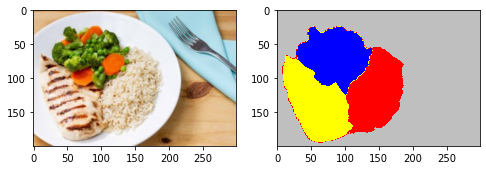

Ground truth Codes [0 1 2 3]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/done/176.jpg


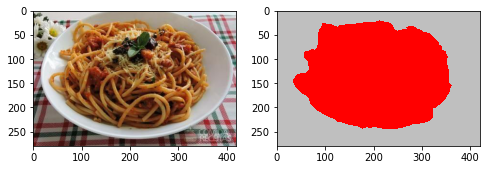

Ground truth Codes [0 1]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/done/976.jpg


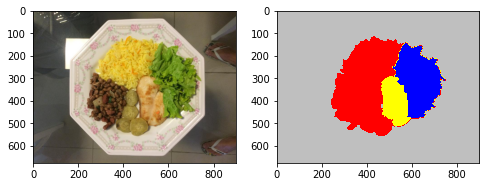

Ground truth Codes [0 1 2 3]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/done/469.jpg


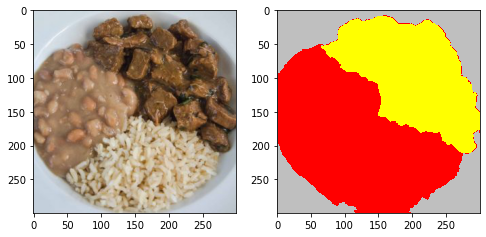

Ground truth Codes [0 1 2]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/done/165.jpg


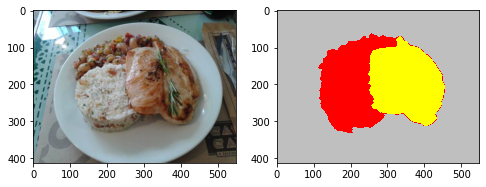

Ground truth Codes [0 1 2]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint5/done/643.jpg


In [ ]:
### VISUALIZACAO DA MÁSCARA FICA COM A BORDA ESTRANHA, MAS ELA ESTÁ CORRETA COMO PODE SER VISTO NOS CODIGOS DO GROUND TRUTH

for idx in range(0,5):
  fig = plt.figure(figsize=(8,8))

  img = Image.open(fnames[idx])
  arr = np.asarray(img)
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(arr)

  img1 = get_y_fn(fnames[idx]) # use this when 'adjustedGroundTruthIds' is necessary
  # img1 = Image.open(get_y_fn(fnames[idx]))
  arr = np.asarray(img1)
  ax1 = fig.add_subplot(1,2,2)
  ax1.imshow(arr, cmap=cmap, norm=norm)
  plt.show()

  print("Ground truth Codes", np.unique(arr,return_counts=False))
  print(fnames[idx])


## Data Augmentation

In [ ]:
size = (256, 256)
item_tfms = [Resize(size, method=ResizeMethod.Squish, resamples=(Image.NEAREST,Image.NEAREST))]
aug_tfms = aug_transforms(mult=1, flip_vert=True, size=size)

## Dataloaders

In [ ]:
# dataset balance method. choose one of them or none

lossClassWeights = None
sampler = None

#### load class weights from pickle ####
# with open( path + "classWeightsSprint1.pkl", 'rb') as f:
#   weights = pickle.load(f)
# classWeights = torch.FloatTensor(weights).cuda() 

#### assign class weights empirically ####
# classWeights = torch.ones(len(codes)).cuda()
# classWeights[0] = 0.1

### 1. class weights in loss function ###
# lossClassWeights = classWeights

### 2. oversampling ### not yet implemented, check here https://forums.fast.ai/t/oversampling-in-fastai2/73721/14

# sampler = torch.utils.data.sampler.WeightedRandomSampler(classWeights, len(classWeights))                     
# total_len_oversample = int(learn.data.c*np.max(label_counts))
# dataloaders.train_dl.dl.batch_sampler = BatchSampler(WeightedRandomSampler(weights,total_len_oversample), data.train_dl.batch_size,False)

In [ ]:
# get data split from files or function

#### split train/test randomly ####
#from sklearn.model_selection import train_test_split
#X_train, X_test, _, _ = train_test_split(fnames, label_fnames, test_size=0.2, random_state=randomSeed, shuffle=True, stratify=None)

#### split by validation.txt ####
# testFiles = np.loadtxt(path + 'validation.txt', dtype=str, delimiter='\n',encoding='utf')
# X_test = [file for file in fnames if file.name in testFiles]

#### split by filenames array from pickle ####
import pickle
with open(path + "testFilenamesSprint0.pkl", 'rb') as f:
  testFiles = pickle.load(f)
X_test = [file for file in fnames if file.name in testFiles]

In [ ]:
bs = 8 # batch size
gradientAcc = int(32/bs) # 32 is the final "batch size"

trainBlock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FuncSplitter(lambda o: o in X_test),
                   get_y=get_y_fn,
                   item_tfms=item_tfms, 
                   batch_tfms=[*aug_tfms, Normalize.from_stats(*imagenet_stats)])

dataloaders = trainBlock.dataloaders(path_img, path=path, bs=bs)

#### test dataloader #### 
test_dl = dataloaders.test_dl(X_test, with_labels=True)
test_dl.vocab = codes

In [ ]:
len(dataloaders.train_ds), len(dataloaders.valid_ds), len(test_dl.dataset)

(344, 87, 87)

In [ ]:
dataloaders.train.show_batch(max_n=4, figsize=(7, 7), cmap=cmap, norm=norm,alpha=0.9)

In [ ]:
dataloaders.valid.show_batch(max_n=4, figsize=(7, 7), cmap=cmap, norm=norm,alpha=0.9)

In [ ]:
test_dl.show_batch(max_n=4, figsize=(7, 7), cmap=cmap, norm=norm,alpha=0.9)

## Metrics

In [ ]:
from fastaiMetrics import acc_segmentation, MIOU

classes_index = range(1, len(codes)) #exclude background class at index 0
metrics = [acc_segmentation, DiceMulti, MIOU(classes_index, axis=1)]

## Model

In [ ]:
# EarlyStoppingCallback(monitor='miou',patience=50) -> if patience is too high, this may cause error in learner.validate()
modelCallbacks = [ShowGraphCallback]
opt_func = Adam

from fastaiCustomLosses import CombinedLossTunable
# loss_func = CrossEntropyLossFlat(weight=lossClassWeights, axis=1)
# loss_func = FocalLossFlat(weight=lossClassWeights, axis=1)
loss_func = CombinedLossTunable()

learner = unet_learner(dataloaders, resnet34, loss_func=loss_func, opt_func=opt_func, metrics=metrics, cbs=modelCallbacks,
                       self_attention=False, act_cls=Mish).to_fp32()

In [ ]:
#learner.model[0].load_state_dict(torch.load(path_to_drive + 'DiabetesLearning/trainingConfig/resnet34_encoder-food101.h5'), strict=True); #load preTrained from FOOD101

In [ ]:
# learner.load(path + 'stage-2-brazilFoods', strict=False)
# learner.load_state_dict(torch.load(path + 'stage-2-brazilFoods.pth'), strict=False)
# learner.model.load_state_dict(torch.load(path + 'stage-2-brazilFoods.pth'), strict=False)
# test = Learner(dataloaders,resnet34)
# learner.load('stage-1-best')

## Training

SuggestedLRs(valley=5.248074739938602e-05)

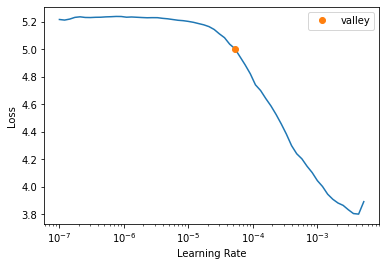

In [ ]:
learner.lr_find()

In [ ]:
lr = 5e-4
freezeEpochs = 1
unfreezeEpochs = 25
wd = 1e-2
learner.freeze()

epoch,train_loss,valid_loss,acc_segmentation,dice_multi,miou,time
0,0.188583,0.402459,0.776838,0.710070,0.558652,00:19


Better model found at epoch 0 with miou value: 0.5586520814091143.


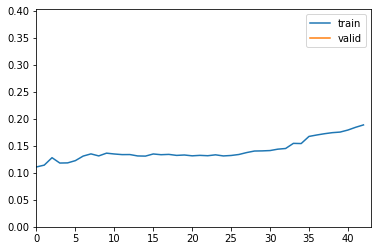

epoch,train_loss,valid_loss,acc_segmentation,dice_multi,miou,time
0,0.181915,0.363855,0.807402,0.725126,0.579594,00:21
1,0.162536,0.392633,0.807016,0.731059,0.583663,00:21
2,0.154425,0.385382,0.801066,0.724748,0.581458,00:21
3,0.155121,0.403373,0.805612,0.739364,0.592942,00:20
4,0.153483,0.386093,0.807469,0.733296,0.585369,00:21
5,0.160102,0.390949,0.787071,0.729852,0.575583,00:20
6,0.174341,0.375339,0.799983,0.727078,0.572230,00:20
7,0.174234,0.432104,0.782723,0.734975,0.577109,00:21
8,0.172134,0.349428,0.812963,0.752666,0.609496,00:21
9,0.176872,0.350273,0.816621,0.754658,0.612305,00:21


Better model found at epoch 0 with miou value: 0.5795943713457374.


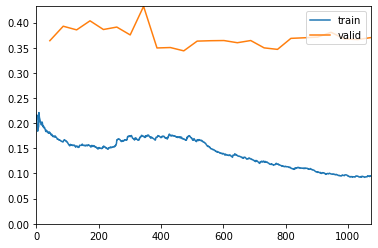

Better model found at epoch 1 with miou value: 0.5836634528410983.
Better model found at epoch 3 with miou value: 0.5929418873631717.
Better model found at epoch 8 with miou value: 0.6094956019099222.
Better model found at epoch 9 with miou value: 0.6123046853473804.
Better model found at epoch 10 with miou value: 0.6171169692331351.
Better model found at epoch 12 with miou value: 0.6174328830773523.
Better model found at epoch 14 with miou value: 0.648617494000799.


epoch,26
train_loss,0.09492
raw_loss,0.06101
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
wd_1,0.01
sqr_mom_1,0.99
lr_1,0.0


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,▄▄█▆▆▆▅▅▅▅▅▆▆▆▇▆▆▇▆▆▆▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁
raw_loss,▃▄▂▂▄▂▂▂▂▂▃▃█▂▅▄▃▃▂▂▆▂▂▁▂▁▂▁▁▂▂▃▂▁▂▂▁▂▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▄█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_0,▆▂██▇▆▅▄▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▅▅▆▆▆▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▄█▂▂▂▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁


In [ ]:
run = wandb.init(project="diabetesLearning") # track machine learning experiment
fitCallbacks = [WandbCallback(log='all'), SaveModelCallback(every_epoch=False, monitor='miou', fname='stage-1-best',with_opt=True), GradientAccumulation(n_acc=gradientAcc)]
# learner.fit_one_cycle(epochs, slice(lr), pct_start=0.8, wd=wd, cbs=fitCallbacks)
# learner.fit_flat_cos(epochs, slice(lr), wd=wd,cbs=fitCallbacks)
learner.fine_tune(unfreezeEpochs, base_lr=lr, freeze_epochs=freezeEpochs, pct_start=0.3, wd=wd, cbs=fitCallbacks)
run.finish()

## Fine-tunning (optional)

In [ ]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

In [ ]:
# learner = unet_learner(dataloaders, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=metrics, cbs=callbacks,
#                        wd_bn_bias=True).to_fp16()
# learner.load('stage-1-best')


In [ ]:
learner.unfreeze()
# learner.lr_find()

In [ ]:
lrs = slice(lr/400,lr/4)
epochs = 50
wd = 1e-2

epoch,train_loss,valid_loss,acc_segmentation,dice_multi,miou,time
0,0.443479,0.832528,0.532327,0.256014,0.118144,02:15
1,0.419501,0.806147,0.544782,0.271664,0.126363,02:14
2,0.403940,0.828603,0.533374,0.258908,0.119813,02:15
3,0.397915,0.831908,0.537469,0.274561,0.128003,02:15
4,0.402978,0.828310,0.528577,0.270263,0.125514,02:15
5,0.376559,0.835561,0.534543,0.280300,0.130349,02:14
6,0.383563,0.833254,0.534618,0.282890,0.132608,02:16
7,0.342848,0.858938,0.526259,0.275354,0.127085,02:15
8,0.356883,0.832172,0.540758,0.299238,0.140044,02:15
9,0.331411,0.850221,0.529885,0.289319,0.134324,02:16


/content/drive/My Drive/Colab Notebooks/DiabetesLearning/fastaiMetrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  iou_index = per_class_TP / (per_class_TP + per_class_FP + per_class_FN)


Better model found at epoch 0 with acc_segmentation value: 0.5323270559310913.


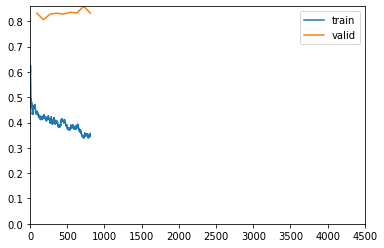

Better model found at epoch 1 with acc_segmentation value: 0.5447819232940674.
No improvement since epoch 1: early stopping


epoch,46
train_loss,0.33141
raw_loss,0.16842
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,0.0
beta_0,0.0
wd_1,0.01
sqr_mom_1,0.99


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,▇█▅▅▅▄▅▄▄▃▄▃▃▃▂▂▃▃▄▂▂▃▃▂▂▂▃▂▂▂▃▂▁▁▂▂▁▂▂▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,███████████████████████████████▁▁▁▁▁▁▁▁▁
mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
#run = wandb.init(project="diabetesLearning") # track machine learning experiment
fitCallbacks = [WandbCallback(log='all'), SaveModelCallback(every_epoch=False, monitor='acc_segmentation', fname='stage-2-best',with_opt=True),GradientAccumulation(n_acc=gradientAcc)]
# learner.fit_one_cycle(epochs, lrs, pct_start=0.3, wd=wd, cbs=fitCallbacks)
learner.fit_flat_cos(epochs, lrs, wd=wd, cbs=fitCallbacks)
run.finish()

In [ ]:
# learner.load('stage-2-best')
# learner.save('stage-2-size350-bestEpoch')

## FastAI Validation

In [ ]:
id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id

#### fastai metrics names
metricsNames = ["Loss", "Acc_Segmentation", "Dice", "Miou"]

#### add iou per class if you want
from fastaiMetrics import IOU
iouPerClass = []
for x in range(1,len(codes)): iouPerClass.append(IOU(x, codes[x], axis=1, ignore_index=0)) #ignore background idx 0
learner.metrics = metrics + iouPerClass
metricsNames += ["Iou " + codes[x] for x in range(1,len(codes))]

#### LOAD ONLY IF NECESSARY
# learner = unet_learner(dataloaders, resnet34, metrics=metrics+iouPerClass)
# learner.load('stage-1-best')

In [ ]:
#### check if model overfits ####
trainset = tuple(zip(metricsNames,learner.validate(dl=dataloaders.train)))

#### validate validset ####
validset = tuple(zip(metricsNames,learner.validate(dl=dataloaders.valid)))

"Trainset", trainset, "Validset", validset

('Trainset',
 (('Loss', 0.02755793370306492),
  ('Acc_Segmentation', 0.9537791013717651),
  ('Dice', 0.9573008065624846),
  ('Miou', 0.9422343328130169),
  ('Iou Carbs', 0.9327461677416321),
  ('Iou Proteina', 0.9141959532173162),
  ('Iou Vegetais', 0.9314359032125074),
  ('Iou Frutas', 0.921803159355188)),
 'Validset',
 (('Loss', 0.15403492748737335),
  ('Acc_Segmentation', 0.8400511741638184),
  ('Dice', 0.7950899679457022),
  ('Miou', 0.6651723648813872),
  ('Iou Carbs', 0.7581479285091804),
  ('Iou Proteina', 0.6981870425535122),
  ('Iou Vegetais', 0.7938424216521796),
  ('Iou Frutas', 0.3190084457606669)))

In [ ]:
#### validate testset ####
# learner.dls.valid = test_dl
# testset = tuple(zip(metricsNames,learner.validate(dl=test_dl)))
# "Testset", testset

In [ ]:
dl = dataloaders.valid

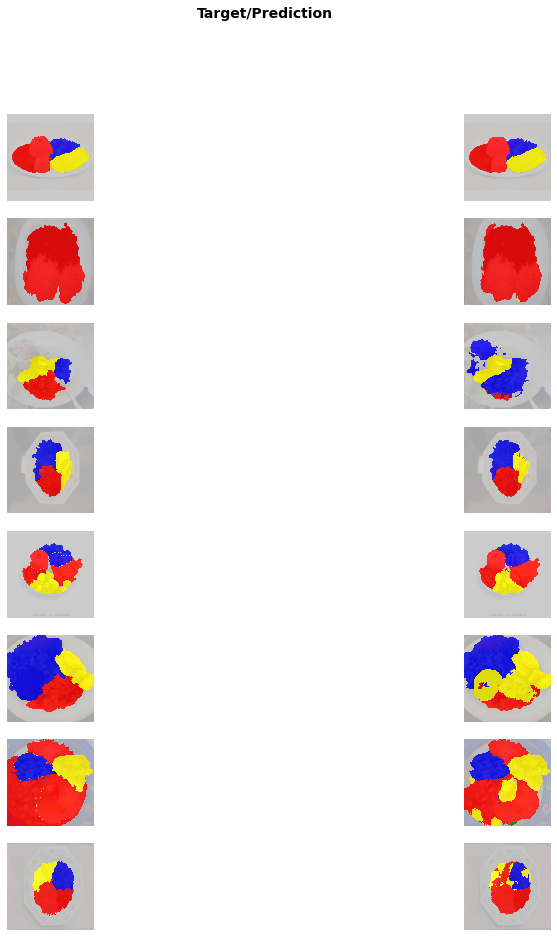

In [ ]:
learner.show_results(dl=dl, figsize=(15,15), max_n=40, cmap=cmap, norm=norm,alpha=0.8)

In [ ]:
# interp = Interpretation.from_learner(learner, dl=test_dl)
# losses,idxs = interp.top_losses()
# interp.plot_top_losses(4, figsize=(15,11), cmap=cmap, norm=norm)

In [ ]:
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
#interp.most_confused(min_val=10)

## Sklearn Validation

In [ ]:
from sklearnMetrics import Metrics
void_code = 0
metricsObject = Metrics(codes, [void_code])
id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id

# LOAD ONLY IF NECESSARY
# learner = unet_learner(dataloaders, resnet34, metrics=metrics)
# learner.load('stage-1-best')

In [ ]:
#input, probabilities, groundTruth, decoded, losses = learner.get_preds(dl=dl,  with_input=True, with_loss=True, with_decoded=True, act=F.softmax) #inputs, preds, groundTruth, losses
input, probabilities, groundTruth, decoded = learner.get_preds(dl=dl,  with_input=True, with_loss=False, with_decoded=True, act=F.softmax) #inputs, preds, groundTruth, losses

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:255: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  res[pred_i] = act(res[pred_i])


In [ ]:
print(metricsObject.getAccuracy(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

0.8394657058144419


In [ ]:
print(metricsObject.get_f1Score(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

0.8410215281288161


In [ ]:
confusionMatrix = metricsObject.getConfusionMatrix(decoded.flatten().numpy(), groundTruth.flatten().numpy(), plot=False)

In [ ]:
mostConfused = metricsObject.mostConfused(confusionMatrix, numberOfConfusions=4)

print("Actual", "   Predicted", "   Wrong pixels\n")
mostConfused

Actual    Predicted    Wrong pixels



[['Carbs', 'Proteina', 83688],
 ['Proteina', 'Carbs', 68403],
 ['Carbs', 'Vegetais', 54325],
 ['Proteina', 'Vegetais', 28587]]

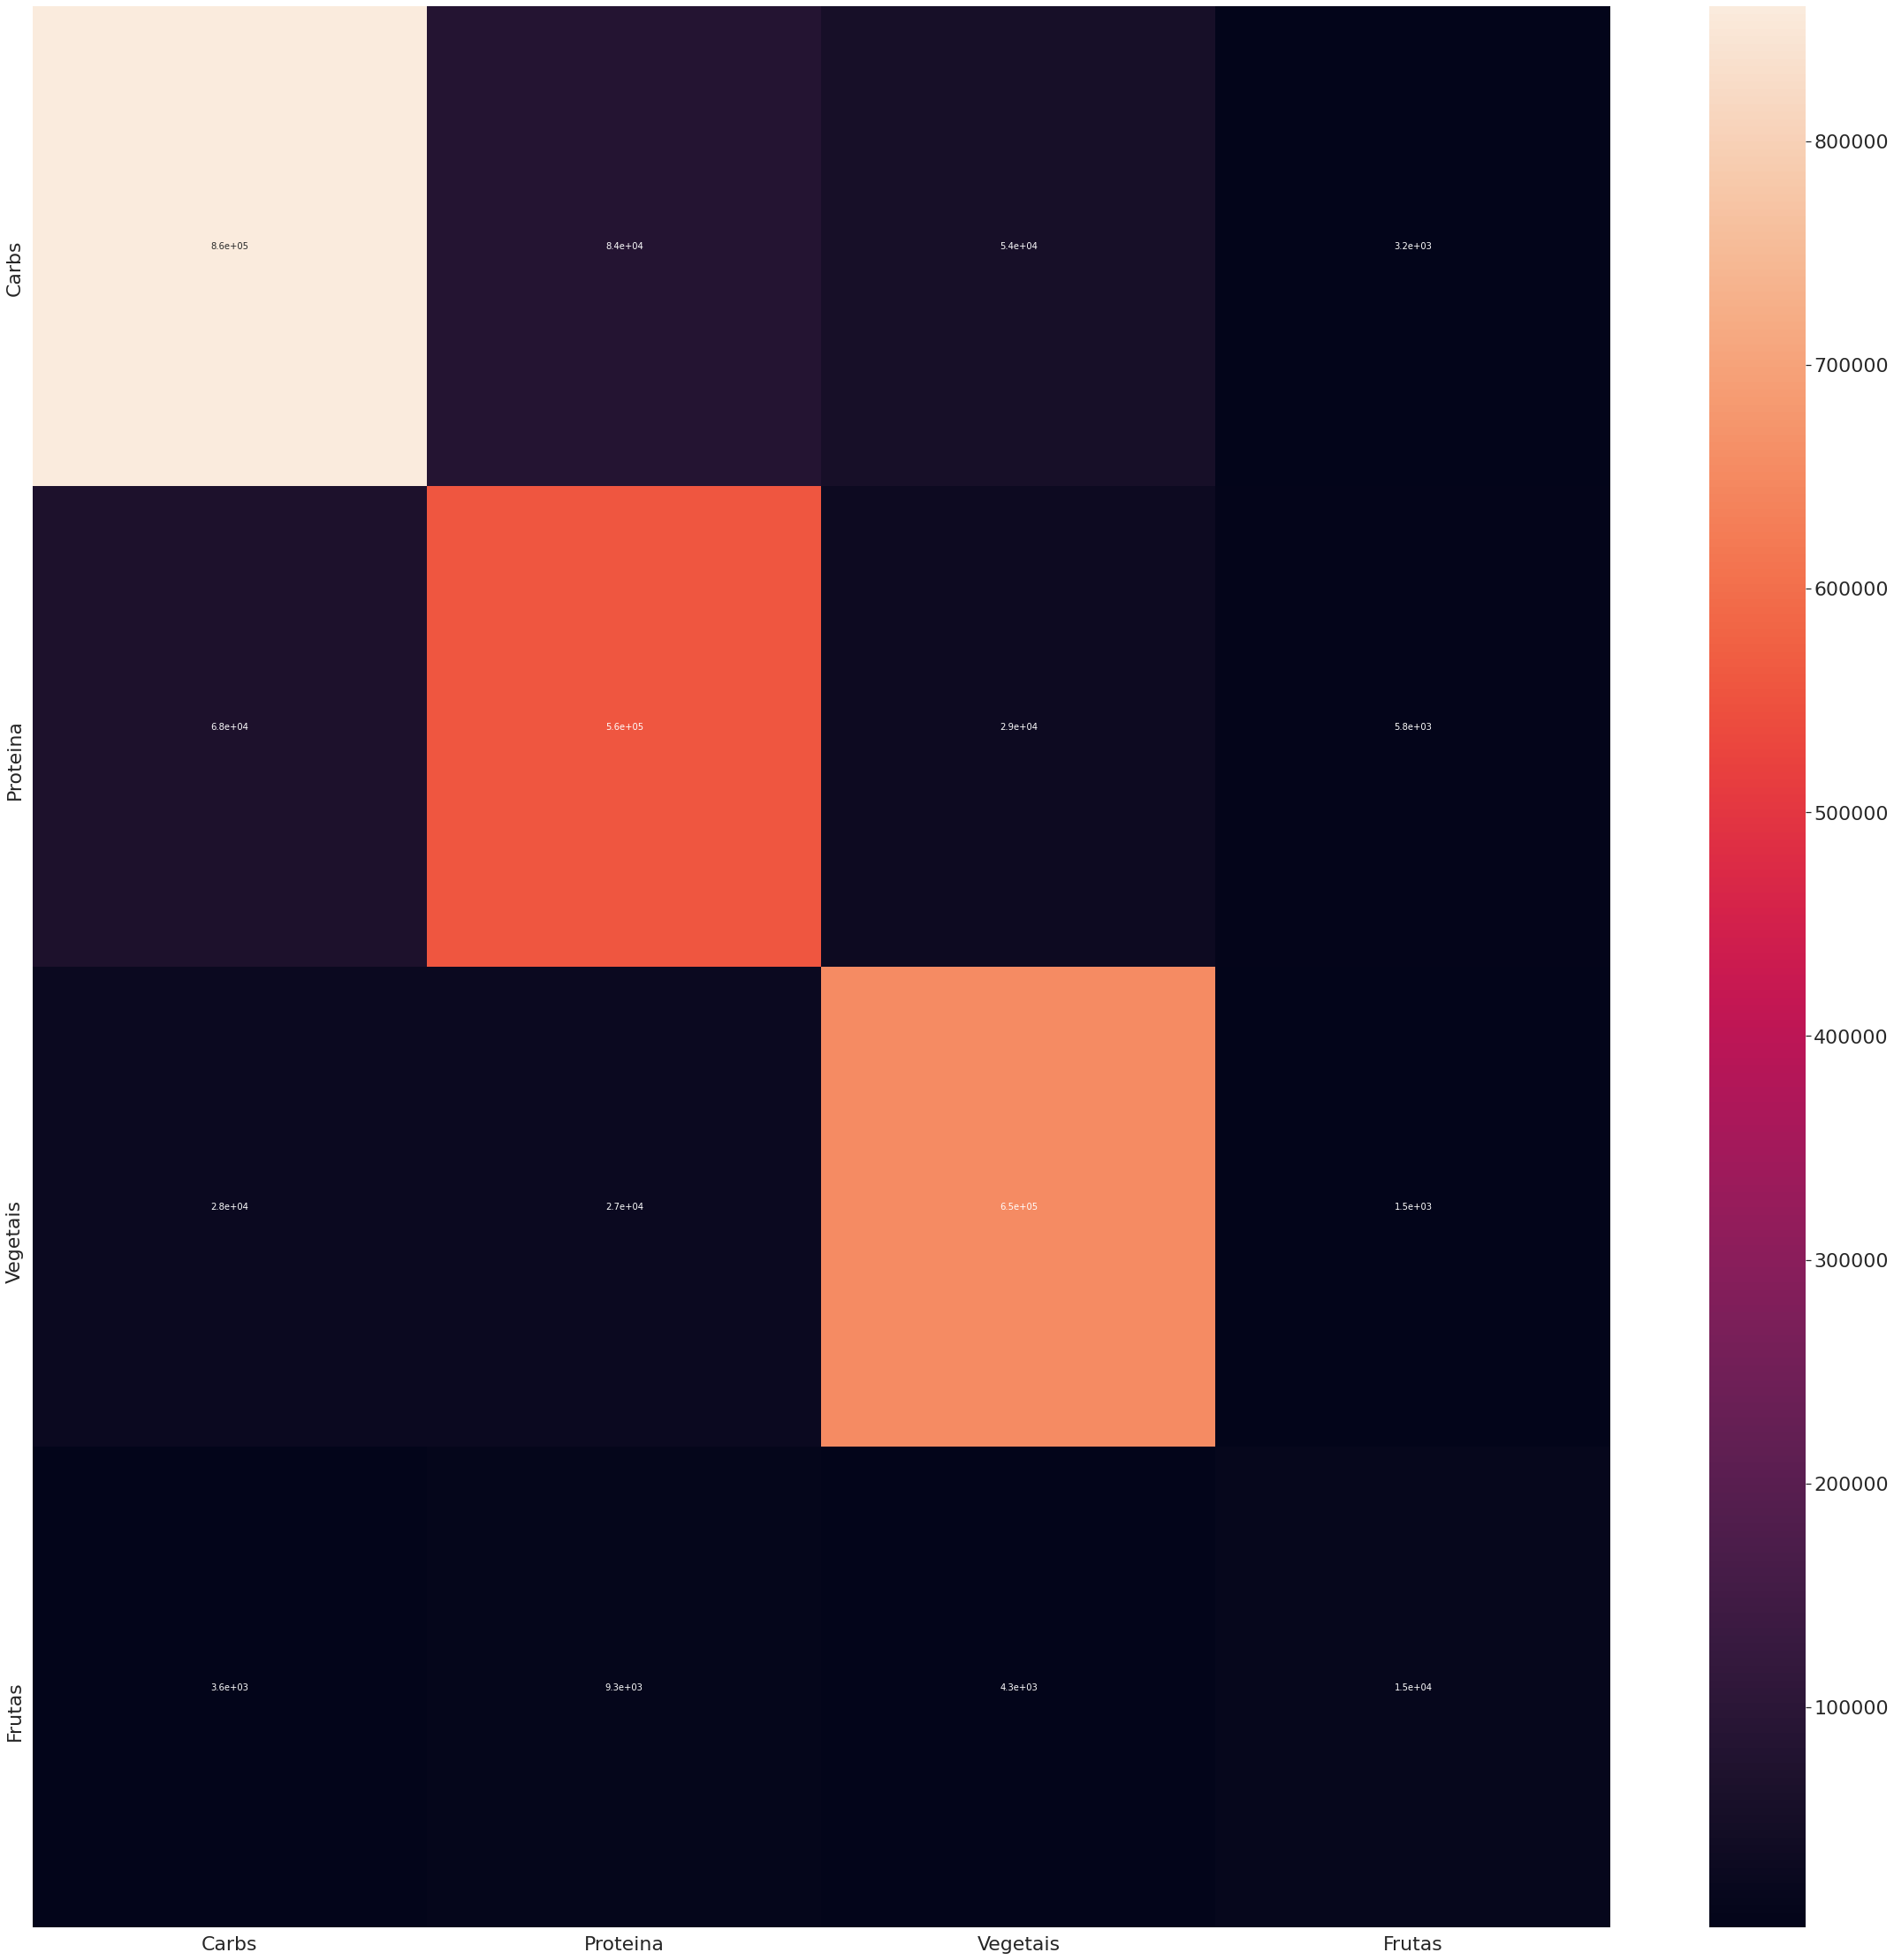

In [ ]:
#plot confusion matrix (take some time, too big the matrix). Think in a better way to visualize (check for most confuseds)

metricsObject.plotConfusionMatrix(confusionMatrix, font_scale=2, removeDiagonal=False)

In [ ]:
print(metricsObject.getClassificationReport(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

              precision    recall  f1-score   support

       Carbs       0.87      0.83      0.85   1035158
    Proteina       0.81      0.82      0.82    676648
    Vegetais       0.85      0.89      0.87    736392
      Frutas       0.53      0.41      0.47     35153

   micro avg       0.84      0.84      0.84   2483351
   macro avg       0.77      0.74      0.75   2483351
weighted avg       0.84      0.84      0.84   2483351



## Check some particular image details

In [ ]:
from collections import OrderedDict

id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id

def getFoodsInImage(tensor, removeVoid=False):
    foods, counts = np.unique(tensor,return_counts=True)
    if removeVoid:
        counts = np.delete(counts, 0) #tira o void na posicao 0 do array
        foods = np.delete(foods, 0) #tira o void na posicao 0 do array
    
    foodNames = []
    print(f'Numero de alimentos: {len(foods)}')
    for food in foods:
        foodNames = np.append(foodNames,id2name[food])
    dictCounts = dict(zip(foodNames, counts))
    dictCounts = OrderedDict(sorted(dictCounts.items(), key=lambda x: x[1], reverse=True))
    print(dictCounts)
    return dictCounts

def getMostAppearances(foodCountsDict, k = 3):
    sortedDict = OrderedDict(sorted(foodCountsDict.items(), key=lambda x: x[1], reverse=True))
    topKDict = {}
    for count, (key, v) in enumerate(foodCountsDict.items()):
        if count == k:
            break
        elif key != "NaoAlimento":
            topKDict[key] = v
        else:
            k += 1 # increment k if find NaoAlimento in the first positions
    
    return topKDict
        


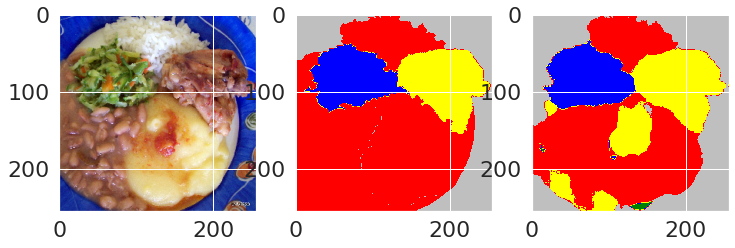

In [ ]:
idx = 6
fig = plt.figure(figsize=(12,12))

# denorm to original image
rawImage = copy(input[idx])

nrm = Normalize.from_stats(*imagenet_stats)
image = nrm.decode(rawImage) #fastai version 2.3.1 needs two denorms!!!! FUCK YOU FASTAI!!!
image = nrm.decode(image).clamp(0,1).squeeze().permute(1,2,0) # denorm image from imagenet stats

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(image)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(groundTruth[idx], cmap=cmap, norm=norm)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(decoded[idx], cmap=cmap, norm=norm)

In [ ]:
print("Ground truth\n")
sample = groundTruth[idx]
gtDictCounts = getFoodsInImage(sample)


Ground truth

Numero de alimentos: 4
OrderedDict([('Carbs', 36171), ('NaoAlimento', 14300), ('Proteina', 8115), ('Vegetais', 6950)])


In [ ]:
print("Prediction\n")
sample = decoded[idx]
decodedDictCounts = getFoodsInImage(sample)


Prediction

Numero de alimentos: 5
OrderedDict([('Carbs', 25732), ('NaoAlimento', 19203), ('Proteina', 13139), ('Vegetais', 7257), ('Frutas', 205)])


In [ ]:
# get low prob classes

bestProbs, bestProbsIdx = torch.max(probabilities[idx], dim=0)
lowProbs = []
lowProbsIdx = []

mask = bestProbs < 0.5
lowProbsIdx = bestProbsIdx[mask]
lowProbDictCounts = getFoodsInImage(lowProbsIdx)

print("\nPercentual de pixeis com baixa probabilidade\n")
for key, value in lowProbDictCounts.items():
    pct = float(value/decodedDictCounts[key]*100)
    print(key, '{:.2f}'.format(pct), "%" )

Numero de alimentos: 5
OrderedDict([('Carbs', 15695), ('Proteina', 6658), ('NaoAlimento', 3616), ('Vegetais', 2058), ('Frutas', 205)])

Percentual de pixeis com baixa probabilidade

Carbs 60.99 %
Proteina 50.67 %
NaoAlimento 18.83 %
Vegetais 28.36 %
Frutas 100.00 %


In [ ]:
# get high prob classes

bestProbs, bestProbsIdx = torch.max(probabilities[idx], dim=0)

mask = bestProbs > 0.5
highProbsIdx = bestProbsIdx[mask]
highProbDictCounts = getFoodsInImage(highProbsIdx)

print("\nPercentual de pixeis com alta probabilidade\n")
for key, value in highProbDictCounts.items():
    pct = float(value/decodedDictCounts[key]*100)
    print(key, '{:.2f}'.format(pct), "%" )

Numero de alimentos: 5
OrderedDict([('Carbs', 24024), ('NaoAlimento', 18602), ('Proteina', 11822), ('Vegetais', 6995), ('Frutas', 80)])

Percentual de pixeis com alta probabilidade

Carbs 93.36 %
NaoAlimento 96.87 %
Proteina 89.98 %
Vegetais 96.39 %
Frutas 39.02 %


## Predictions of new input data

In [ ]:
# always load it!

learner = unet_learner(dataloaders, resnet34, self_attention=False, act_cls=Mish)
learner.load('stage-1-best')

In [ ]:
#input should be a PIL object

index = 50
img = dataloaders.valid_ds[index][0]

# img_pil = Image.open("3.jpg")
# img = np.asarray(img_pil.resize((400,400)))

pred = learner.predict(img)

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(pred[0],cmap=cmap)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img)

foods = getFoodsInImage(pred[0])
k = 3
mostAppear = list(getMostAppearances(foods, k=k).keys())
print('\n{} principais alimentos:'.format(k),mostAppear)

## REMOVE THIS LATER (TOMAS)

In [ ]:
from sklearn.preprocessing import label_binarize

mask = groundTruth.unsqueeze(dim=1)!=0
gtOneHotEncoded = label_binarize(groundTruth.flatten().numpy(), classes=range(len(codes)))

# groundTruthIgnoringBackground = groundTruth[mask.squeeze()]
# gtOneHotEncoded = label_binarize(groundTruthIgnoringBackground.flatten().numpy(), classes=range(len(codes)))

# probabilitiesIgnoringBackground = probabilities[mask.unsqueeze(dim=1)]
probabilities = probabilities.reshape((-1,16,256*256))
probabilities = probabilities.permute(0,2,1)
probabilities = probabilities.reshape((-1,16))

flatMask = mask.flatten()
# probabilitiesIgnoringBackground = np.array([Tensor(probabilities[i,:]) for i in range(len(flatMask[:100000])) if flatMask[i] == True])
# probabilitiesIgnoringBackground = probabilities[mask.flatten().unsqueeze(dim=1)]

flatMask.shape, probabilities.shape, gtOneHotEncoded.shape

(torch.Size([5636096]), torch.Size([5636096, 16]), (5636096, 16))

In [ ]:
# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(gtOneHotEncoded.ravel(), probabilities.ravel())
roc_auc = auc(fpr, tpr)

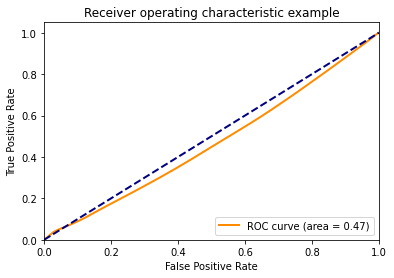

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()